# Data-Driven Dynamic Pricing in the Hotel Industry

## Table of Contents
1. [Problem Setup](#problem-setup)
2. [Implementation Steps](#implementation-steps)
    - [Define Booking Classes](#1-define-booking-classes)
    - [Define State Space](#2-define-state-space)
    - [Define Pricing and Demand Functions](#3-define-pricing-and-demand-functions)
    - [Implement Dynamic Programming](#4-implement-dynamic-programming)
    - [Visualize Results](#5-visualize-results)

## Problem Setup

We aim to optimize room pricing for a hotel with limited capacity over a short booking horizon. Specifically:

- **Capacity $C$**: 5 rooms
- **Service Horizon $N$**: 3 days
- **Booking Horizon $T$**: 2 booking periods

**Booking Classes**: Customers can book rooms for stays spanning multiple days. Each booking class is defined by its arrival and departure days.

Our goal is to determine the optimal pricing strategy that maximizes total revenue over the booking horizon while considering customer behavior and room availability.

## Implementation Steps

### 1. Define Booking Classes
First, we need to define all possible booking classes based on the service horizon. A booking class is characterized by its arrival day $a^b$ and departure day $d^b$.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define BookingClass as a data structure
class BookingClass:
    def __init__(self, id, arrival, departure):
        """
        Initializes a booking class.

        Parameters:
        - id: Unique identifier for the booking class
        - arrival: Arrival day (a^b)
        - departure: Departure day (d^b)
        """
        self.id = id
        self.arrival = arrival
        self.departure = departure
        self.length = departure - arrival + 1  # L^b
        self.stay_days = list(range(arrival, departure + 1))  # N^b
        
        def capacity_consumption(self):
            """
            Returns the capacity consumption vector e^b.
            """
            e_b = [0] * 3  # Since N=3
            for day in self.stay_days:
                e_b[day - 1] = 1
            return tuple(e_b)

In [3]:
# Initialize booking classes for N=3
def initialize_booking_classes(N):
    """
    Generates all possible booking classes for the service horizon.

    Parameters:
    - N: Number of service days

    Returns:
    - List of BookingClass instances
    """
    booking_classes = []
    id_counter = 1
    for a, d in itertools.product(range(1, N + 1), repeat=2):
        if a <= d:
            booking_classes.append(BookingClass(id=id_counter, arrival=a, departure=d))
            id_counter += 1
    return booking_classes

In [4]:
# Initialize booking classes
N = 3
booking_classes = initialize_booking_classes(N)
print("Defined Booking Classes:")
for bc in booking_classes:
    print(f"Class {bc.id}: Arrival Day {bc.arrival}, Departure Day {bc.departure}, Stay Days {bc.stay_days}")

Defined Booking Classes:
Class 1: Arrival Day 1, Departure Day 1, Stay Days [1]
Class 2: Arrival Day 1, Departure Day 2, Stay Days [1, 2]
Class 3: Arrival Day 1, Departure Day 3, Stay Days [1, 2, 3]
Class 4: Arrival Day 2, Departure Day 2, Stay Days [2]
Class 5: Arrival Day 2, Departure Day 3, Stay Days [2, 3]
Class 6: Arrival Day 3, Departure Day 3, Stay Days [3]


### 2. Define State Space
The state of the system is represented by the remaining capacity for each day in the service horizon. Given $C=5$ and $N=3$, each state is a tuple ($x_1, x_2, x_3$) where $0\leq x_i\leq 5$.

In [5]:
# Define the state space
def generate_all_spaces(C, N):
    """
    Generates all possible states based on capacity and service horizon.

    Parameters:
    - C: Total capacity
    - N: Number of service days

    Returns:
    - List of state tuples
    """
    return list(itertools.product(range(C + 1), repeat=N))

In [6]:
# Initialize states
C = 5
states = generate_all_spaces(C, N)
print(f"\nTotal number of states: {len(states)}")
print("Sample states:")
print(states[:5])


Total number of states: 216
Sample states:
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]


**Explanation:** For $C=5$ and $N=3$, there are $6^3=216$ possible states.

### 3. Defining Pricing and Demand Functions

We need to define how pricing effects demand. For simplicity, we'll assume:
- **Reservation Price Distribution** ($F^b(q)$): Uniform distribution between 50 and 150.
- **Arrival Probabilities** ($\pi_t^b$): Fixed probabilities for erach booking class and time period.
- **Pricing Decisions** ($p_t$): Discrete price levels (50, 100, 150) for each day.

#### a. Reservation Price Distribution

In [7]:
# Define the reservation price CDF for uniform distribution between 50 and 150
def reservation_price_cdf(p):
    """
    CDF of the reservation price (uniform distribution between 50 and 150).

    Parameters:
    - p: Offered average price

    Returns:
    - CDF value at price p
    """
    if p < 50:
        return 0.0
    elif p > 150:
        return 1.0
    else:
        return (p-50) / 100.0
    
# Define the survival function (1-CDF)
def survival_function(p):
    """
    Survival function: Pr(q >= p)

    Parameters:
    - p: Offered average price

    Returns:
    - Survival probability
    """
    return 1 - reservation_price_cdf(p)

**Explanation:**

- The reservation price $q$ is uniformly distributed between 50 and 150, which implies a _linear_ demand function.
- The CDF $F^b(p) = \Pr(q \leq p)$ is:
    - $0$ for $p < 50$
    - $\frac{p - 50}{100}$ for $50 \leq p \leq 150$
    - $1$ for $p > 150$
- The survival function $\bar{F}^b(p) = \Pr(q \geq p) = 1 - F^b(p)$.

#### b. Arrival Probabilities
We'll define fixed arrival probabilities $\pi_t^b$ for each booking class $b$ and time period $t$.

For simplicity, assume:
- At each booking period, each booking class has a fixed arrival probability.
- Sum of $\pi_t^b$ across all booking classes must be less than or equal to 1 for each period $t$, ensuring there will be at most one arrival each time period:
$$
\sum_{b\in \mathcal{B}}\pi_t^b\leq 1, \qquad \forall t\in\mathcal{T}
$$

In [8]:
# Number of booking periods
T = 2

# Initialize pi as a dictionary: pi[t][b] = arrival probability
pi = {t: {} for t in range(1, T + 1)}

# Example probabilities (these should sum to <=1 for each t, ensuring at most one arrival each period)
# For simplicity and illustration purpose, assume
# - Each booking class has a 0.1 probability of arrival in each period
for t in range(1, T + 1):
    for bc in booking_classes:
        pi[t][bc.id] = 0.15  # 0.1 probability for each class
        
# Ensure that for each t, sum(pi[t][b]) <=1
for t in pi:
    total_pi = sum(pi[t].values())
    print(f"Total arrival probability at time {t}: {total_pi}")

Total arrival probability at time 1: 0.9
Total arrival probability at time 2: 0.9


**Explanation:**

- We assign a 10% arrival probability to each booking class at each time period.
- With 6 booking classes, the total arrival probability per time period is $6 \times 0.15 = 0.9$, which satisfies $\sum_b \pi_t^b \leq 1$.

#### b. Pricing Decisions
We'll define discrete pricing levels for simplicity and illustration purpose.

In [9]:
# Define discrete price levels for each day in the service horizon.
price_levels = [50, 100, 150]  # Possible prices for each day
# price_levels = np.linspace(50, 150, 10)

# Generate all possible price vectors (combinations of prices for each day)
price_vectors = list(itertools.product(price_levels, repeat=N))
print(f"\nTotal number of price vectors: {len(price_vectors)}")
print("Sample price vectors:")
print(price_vectors[:5])


Total number of price vectors: 27
Sample price vectors:
[(50, 50, 50), (50, 50, 100), (50, 50, 150), (50, 100, 50), (50, 100, 100)]


**Explanation:**
- Each day can have a price of \$50, \$100, or \$150.
- Allow each day to have its own price, resulting in a price vector for the entire service horizon. For instance, Monday price is different from Tuesday price.
- For $N=3$ days and 3 price levels, the total number of possible price vectors is $3^3=27$.

### 4. Implement Dynamic Programming
We'll use dynamic programming to determine the optimal pricing strategy that maximizes expected revenue.

#### a. Initialize Value Function
The value function $V(\mathbf{x}_t, t)$ represents the maximum expected revenue from state $\mathbf{x}_t$ at time $t$.

In [10]:
# Initialize value function as a dictionary: V[state][t]
# States are represented as tuples (x1, x2, x3), representing remaining capacity for each day in the service horizon
# Initialize all V[state][T+1] = 0
V = {state: {t: 0.0 for t in range(1, T + 2)} for state in states}

# Optional: Initialize policy dictionary to store optimal prices
policy = {state: {t: None for t in range(1, T + 1)} for state in states}

**Explanation:**
- For each state and time, we initialize the valye function to zero for $t=T+1$, representing the end of the booking horizon.
- The `policy` dictionary will store the optimal pricing decisions for each state and time.

#### b. Recursive Computation
We'll iterate backwards from $t=T$ to $t=1$, updating the value function based on possible pricing decisions and expetced outcomes.

In [11]:
# Function to check capacity availability
def is_available(state, booking_class):
    """
    Checks if a booking can be accommodated in the current state.

    Parameters:
    - state: Current state tuple
    - booking_class: BookingClass instance

    Returns:
    - True if booking can be accommodated, False otherwise
    """
    for day in booking_class.stay_days:
        if state[day - 1] < 1:
            return False
    return True

# Function to update state after accepting a booking
def update_state(state, booking_class):
    """
    Updates the state by accepting a booking.

    Parameters:
    - state: Current state tuple
    - booking_class: BookingClass instance

    Returns:
    - New state tuple after booking
    """
    new_state = list(state)
    for day in booking_class.stay_days:
        new_state[day - 1] -= 1
    return tuple(new_state)

In [12]:
# Iterate over booking periods in reverse order
for t in range(T, 0, -1):
    print(f"\nProcessing time period t={t}")
    for state in states:
        max_revenue = -np.inf
        optimal_price_vector = None
        # Iterate over possible pricing decisions
        for price_vector in price_vectors:
            # Calculate average prices for each booking class based on the price vector
            # Proceed with revenue and future value calculations
            # Initialize all revenues to zero
            total_revenue = 0.0
            expected_future_revenue = 0.0
            # Immediate revenue
            for bc in booking_classes:
                # Extract prices for the stay days from the price vector
                stay_prices = [price_vector[day - 1] for day in bc.stay_days]
                # Calculate average price for booking class
                avg_price = np.mean(stay_prices)
                
                # Calculate acceptance probability
                acceptance_prob = survival_function(avg_price)
                
                # Expected demand
                lambda_tb = pi[t][bc.id] * acceptance_prob
                
                # Check capacity availability
                if is_available(state, bc):
                    # Revenue from this booking class
                    revenue = bc.length * avg_price * lambda_tb
                    total_revenue += revenue
                    
                    # Update state if booking is accepted
                    new_state = update_state(state, bc)
                    
                    # Add future revenue
                    expected_future_revenue += lambda_tb * V[new_state][t+1]
                else:
                    # Cannot accept booking due to capacity constraint
                    pass
            # Total expected revenue for this pricing decision
            total_expected_revenue = total_revenue + expected_future_revenue
            # Update maximum revenue and optimal price
            if total_expected_revenue > max_revenue:
                max_revenue = total_expected_revenue
                optimal_price_vector = price_vector
        # Update value function and policy
        V[state][t] = max_revenue
        policy[state][t] = optimal_price_vector


Processing time period t=2

Processing time period t=1


**Explanation:**
- **Capacity Check:** For each booking class, we check if there is sufficient capacity to accomodate the booking.
- **Purchase Probability:** Based on the offered average price, we compute the probability that a customer accepts the booking. This purchase probability depends on the average price, which varies per booking class.
- **Expected Demand:** $\lambda_t^b(p_t^b) = \pi_t^b \times \bar{F}^b(p_t^b)$
- **Revenue Calculation:**
    - **Immediate Revenue:** Sum of revenues from all accepted bookings. There will be at most one accepted booking since at most one arrival occurs in each period.
    - **Future Revenue:** Expected revenue from future booking periods based on the updated state after accepting bookins
- **Policy Update:** For each state and time, we store the pricing decision that yields the maximum expected revenue.

### 5. Visualize Results
Let's visualize the optimal pricing strategy and the value function.

#### a. Optimal Pricing Policy
We'll visualize the optimal price for each state at each time period.

In [13]:
# For visualization, we'll select a subset of states for clarity.
# For example, states where total available rooms are <=5

# Function to calculate total available rooms
def total_available(state):
    return sum(state)

# Select states with total available rooms <= 5 (all states)
selected_states = [state for state in states if total_available(state) <= C]

# Extract policies for t = 1 and t = 2
policy_t1 = {state: policy[state][1] for state in selected_states}
policy_t2 = {state: policy[state][2] for state in selected_states}

##### Option 1: Visualize Average Price Across Days

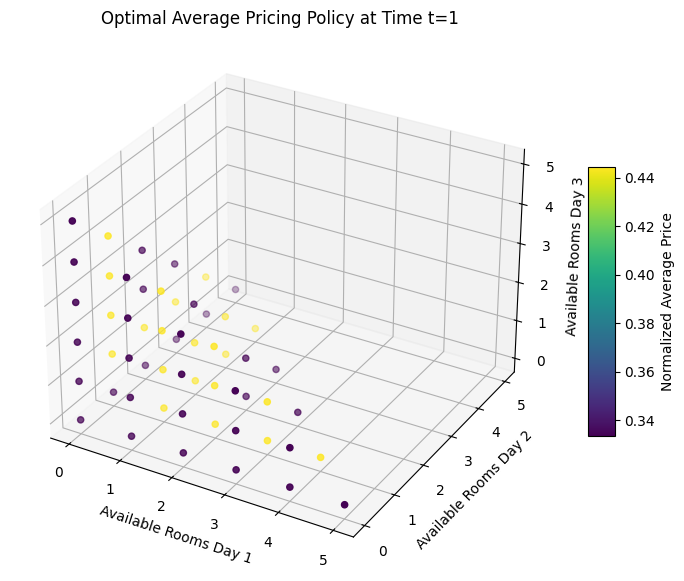

In [14]:
# For simplicity and illustration purpose, we visualize policies for t=1
# We'll plot the optimal price based on the number of available rooms on each day.

# Create a 3D plot where axes are x1, x2, x3 and color represents optimal price
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for plotting t=1
x1 = []
x2 = []
x3 = []
avg_prices = []
for state, price_vector in policy_t1.items():
    x1.append(state[0])
    x2.append(state[1])
    x3.append(state[2])
    
    avg_price = np.mean(price_vector)
    avg_prices.append(avg_price)

# Normalize prices for coloring
price_colors = [price / 150 for price in avg_prices]  # Normalize between 0 and 1

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1, x2, x3, c=price_colors, cmap='viridis')
ax.set_xlabel('Available Rooms Day 1')
ax.set_ylabel('Available Rooms Day 2')
ax.set_zlabel('Available Rooms Day 3')
ax.set_title('Optimal Average Pricing Policy at Time t=1')
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Normalized Average Price')
plt.show()

**Explanations:**
- **Average Price:** Compute the mean of the price vector to represent overall pricing strategy.
- **Color Encoding:** Use normalized average prices to color-code the scatter plot.

##### Option 2: Visualize Prices for Each Day Separately

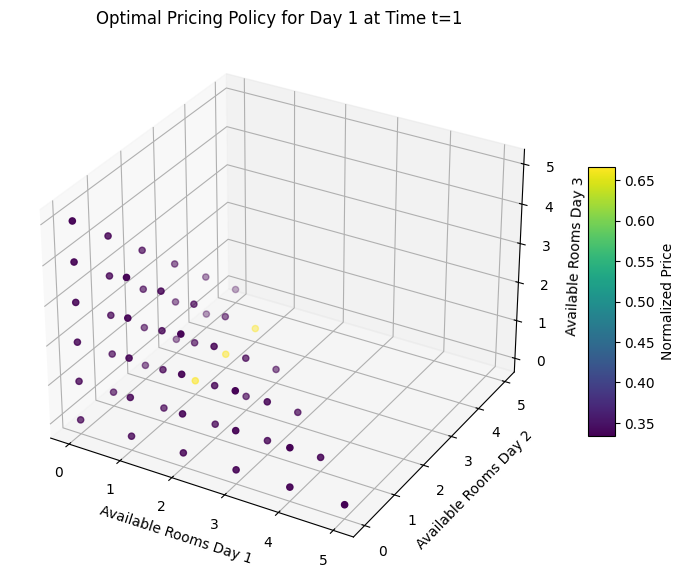

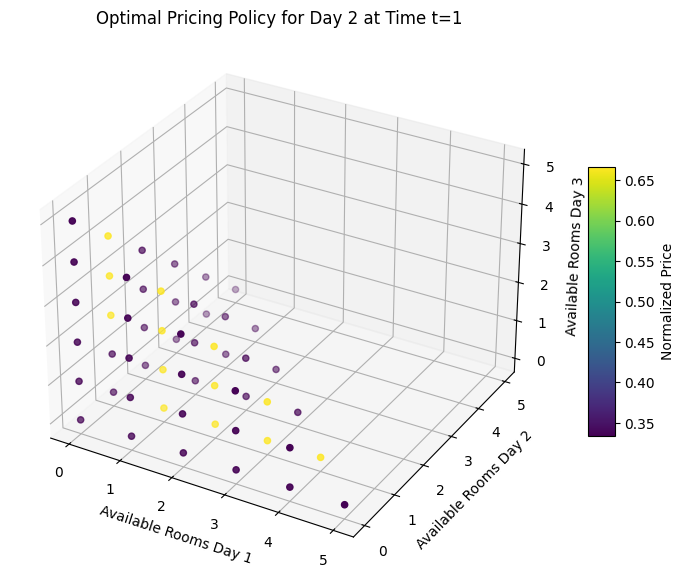

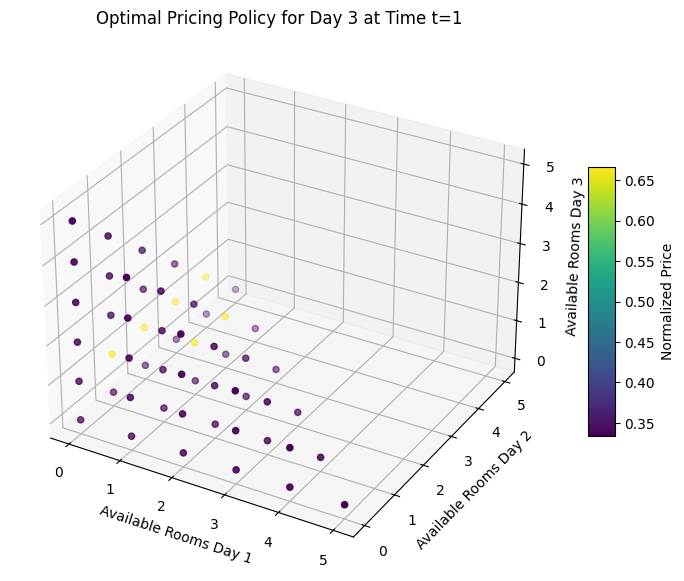

In [15]:
# Prepare separate plots for each day
for day in range(1, N + 1):
    x1 = []
    x2 = []
    x3 = []
    prices_day = []
    for state, price_vector in policy_t1.items():
        x1.append(state[0])
        x2.append(state[1])
        x3.append(state[2])
        prices_day.append(price_vector[day - 1])
    
    # Normalize prices for coloring
    price_colors = [price / 150 for price in prices_day]  # Normalize between 0 and 1
    
    # Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x1, x2, x3, c=price_colors, cmap='viridis')
    ax.set_xlabel('Available Rooms Day 1')
    ax.set_ylabel('Available Rooms Day 2')
    ax.set_zlabel('Available Rooms Day 3')
    ax.set_title(f'Optimal Pricing Policy for Day {day} at Time t=1')
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Normalized Price')
    plt.show()

**Explanation:**

- **Separate Visualizations:** Create individual plots for each day to observe pricing strategies independently.
- **Color Encoding:** Each plot represents the pricing strategy for a specific day, making it easier to analyze day-specific pricing.

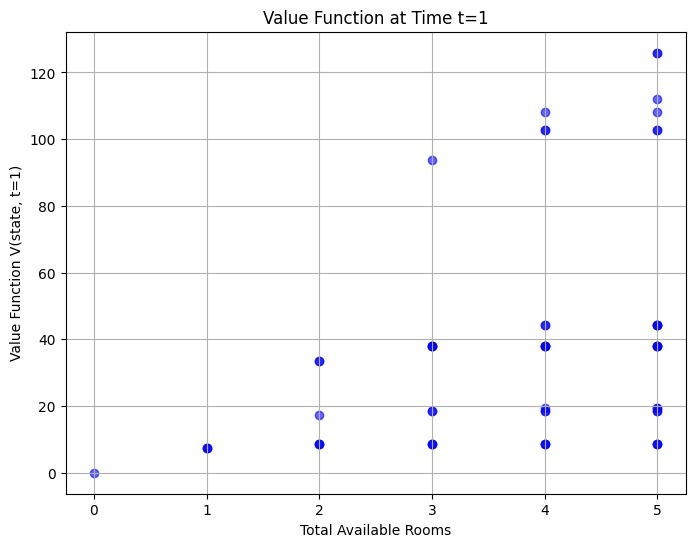

In [16]:
# Visualize value function for t=1
# For simplicity, plot value against total available rooms

total_rooms = [total_available(state) for state in selected_states]
values = [V[state][1] for state in selected_states]

plt.figure(figsize=(8, 6))
plt.scatter(total_rooms, values, c='blue', alpha=0.6)
plt.xlabel('Total Available Rooms')
plt.ylabel('Value Function V(state, t=1)')
plt.title('Value Function at Time t=1')
plt.grid(True)
plt.show()

We can modify the arrival probabilities, pricing levels, or reservation price distributions to explore different scenarios and their impact on the optimal pricing strategy.

In [17]:
V

{(0, 0, 0): {1: 0.0, 2: 0.0, 3: 0.0},
 (0, 0, 1): {1: 7.5, 2: 7.5, 3: 0.0},
 (0, 0, 2): {1: 8.625, 2: 7.5, 3: 0.0},
 (0, 0, 3): {1: 8.625, 2: 7.5, 3: 0.0},
 (0, 0, 4): {1: 8.625, 2: 7.5, 3: 0.0},
 (0, 0, 5): {1: 8.625, 2: 7.5, 3: 0.0},
 (0, 1, 0): {1: 7.5, 2: 7.5, 3: 0.0},
 (0, 1, 1): {1: 33.5625, 2: 31.875, 3: 0.0},
 (0, 1, 2): {1: 38.0625, 2: 31.875, 3: 0.0},
 (0, 1, 3): {1: 38.0625, 2: 31.875, 3: 0.0},
 (0, 1, 4): {1: 38.0625, 2: 31.875, 3: 0.0},
 (0, 1, 5): {1: 38.0625, 2: 31.875, 3: 0.0},
 (0, 2, 0): {1: 8.625, 2: 7.5, 3: 0.0},
 (0, 2, 1): {1: 38.0625, 2: 31.875, 3: 0.0},
 (0, 2, 2): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 2, 3): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 2, 4): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 2, 5): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 3, 0): {1: 8.625, 2: 7.5, 3: 0.0},
 (0, 3, 1): {1: 38.0625, 2: 31.875, 3: 0.0},
 (0, 3, 2): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 3, 3): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 3, 4): {1: 44.34375, 2: 31.875, 3: 0.0},
 (0, 3, 5